Contains additional tests such as convergence, nonlinear least squares, and model comparisons. Added a PINN code since rendering from main class was difficult

In [ ]:
from imports import *
from functions import forward_Euler, analytical_diffusion
from classes import PINN, get_activation, get_optimizer


Testing convergence

Epoch     0 | A=-1.0241, B=-1.3095, C=-3.1415
Epoch   100 | A=-1.1628, B=-5.0654, C=-3.1627
Epoch   200 | A=-1.1555, B=-5.5772, C=-3.1503
Epoch   300 | A=-1.0892, B=-9.3956, C=-3.1453
Epoch   400 | A=-1.0787, B=-9.5742, C=-3.1413
Epoch   500 | A=-1.0664, B=-9.8198, C=-3.1403
Epoch   600 | A=-1.0447, B=-10.0689, C=-3.1413
Epoch   700 | A=-1.0221, B=-10.1550, C=-3.1433
Epoch   800 | A=-1.0152, B=-10.1290, C=-3.1427
Epoch   900 | A=-1.0105, B=-10.0866, C=-3.1421
Epoch  1000 | A=-1.0070, B=-10.0367, C=-3.1420
Epoch  1100 | A=-1.0045, B=-9.9882, C=-3.1422
Epoch  1200 | A=-1.0026, B=-9.9479, C=-3.1425
Epoch  1300 | A=-1.0015, B=-9.9195, C=-3.1426
Epoch  1400 | A=-1.0008, B=-9.9024, C=-3.1427
Epoch  1500 | A=-1.0005, B=-9.8932, C=-3.1426
Epoch  1600 | A=-1.0003, B=-9.8885, C=-3.1426
Epoch  1700 | A=-1.0002, B=-9.8862, C=-3.1426
Epoch  1800 | A=-1.0002, B=-9.8850, C=-3.1426
Epoch  1900 | A=-1.0002, B=-9.8846, C=-3.1426
Epoch  2000 | A=-1.0002, B=-9.8845, C=-3.1425
Epoch  2100 | A=-1.0002, B=-9

C:\Users\Jogga\AppData\Local\Temp\ipykernel_41664\4145374406.py:164: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.semilogy(epoch_hist, np.abs(np.array(A_hist)), label=r"$|A-1|$")


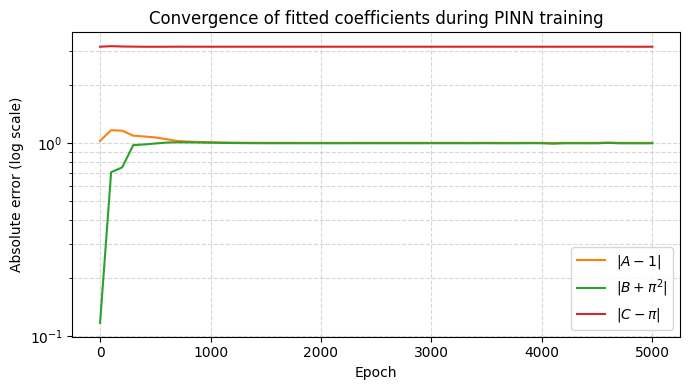

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from scipy.optimize import least_squares


def fit_ABC(x, t, u, theta0):
    """
    Nonlinear least squares fit of
        u(x,t) ≈ A exp(B t) sin(C x)
    """
    def residual(theta):
        A, B, C = theta
        return A*np.exp(B*t)*np.sin(C*x) - u

    res = least_squares(residual, theta0, method="trf")
    return res.x



class PINN(nn.Module):
    """
    PINN for u_t = u_xx on x in [0,1], t in [0,0.5]
    with u(x,0) = sin(pi x), u(0,t)=u(1,t)=0.
    """

    def __init__(self, layers):
        super().__init__()
        modules = []
        for a, b in zip(layers[:-2], layers[1:-1]):
            modules.append(nn.Linear(a, b))
            modules.append(nn.GELU())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*modules)

    def network(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

    def u0(self, x):
        return torch.sin(torch.pi * x)

    def trial_solution(self, x, t):
        return (1 - t)*self.u0(x) + x*(1 - x)*t*self.network(x, t)

    def residual(self, x, t):
        x.requires_grad_(True)
        t.requires_grad_(True)

        u = self.trial_solution(x, t)

        u_t = torch.autograd.grad(
            u, t, torch.ones_like(u), create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, torch.ones_like(u), create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, torch.ones_like(u_x), create_graph=True
        )[0]

        return u_t - u_xx

    def loss(self, x, t):
        return torch.mean(self.residual(x, t)**2)


epochs = 5000
lr = 1e-4
record_every = 100


layers = [2, 200, 200, 200, 200, 200, 1]
model = PINN(layers)

optimizer = optim.Adam(model.parameters(), lr=lr)

N_coll = 100
x_coll = torch.rand(N_coll, 1)
t_coll = 0.5 * torch.rand(N_coll, 1)


x_eval = np.linspace(0, 1, 40)
t_eval = np.linspace(0, 0.5, 40)
Xg, Tg = np.meshgrid(x_eval, t_eval, indexing="ij")
x_fit = Xg.ravel()
t_fit = Tg.ravel()

x_torch_fit = torch.tensor(x_fit, dtype=torch.float32).view(-1,1)
t_torch_fit = torch.tensor(t_fit, dtype=torch.float32).view(-1,1)


theta = np.array([-5, 47, 1e-5])


epoch_hist = []
A_hist = []
B_hist = []
C_hist = []


for ep in range(epochs + 1):
    optimizer.zero_grad()
    loss = model.loss(x_coll, t_coll)
    loss.backward()
    optimizer.step()

    if ep % record_every == 0:
        with torch.no_grad():
            u_pred = model.trial_solution(
                x_torch_fit, t_torch_fit
            ).numpy().ravel()

        theta = fit_ABC(x_fit, t_fit, u_pred, theta)

        epoch_hist.append(ep)
        A_hist.append(theta[0])
        B_hist.append(theta[1])
        C_hist.append(theta[2])

        print(
            f"Epoch {ep:5d} | "
            f"A={theta[0]:.4f}, "
            f"B={theta[1]:.4f}, "
            f"C={theta[2]:.4f}"
        )



A_true = 1.0
B_true = -np.pi**2
C_true = np.pi

plt.figure(figsize=(7,4))
B_log = np.sign(B_hist) * np.log10(np.abs(B_hist))
plt.plot(epoch_hist, B_log)


plt.semilogy(epoch_hist, np.abs(np.array(A_hist)), label=r"$|A-1|$")
plt.semilogy(epoch_hist, np.abs(np.array(B_log)), label=r"$|B+\pi^2|$")
plt.semilogy(epoch_hist, np.abs(np.array(C_hist)), label=r"$|C-\pi|$")

plt.xlabel("Epoch")
plt.ylabel("Absolute error (log scale)")
plt.title("Convergence of fitted coefficients during PINN training")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Define here since rendering from class is difficult

In [16]:
def forward_Euler(dx, T, alpha=0.5, L=1.0):
    """
    Forward Euler for u_t = u_xx on [0,L] with u(x,0)=sin(pi x), u(0,t)=u(L,t)=0.
    Uses dt = alpha * dx^2, so dt/dx^2 = alpha (<= 0.5 for stability).

    Parameters
    ----------
    dx    : float
        Spatial step size.
    T     : float
        Final time to integrate to.
    alpha : float, default 0.5
        Ratio dt/dx^2 (stability requires alpha <= 0.5).
    L     : float, default 1.0
        Length of the rod.

    Returns
    -------
    x : (Nx,) array
    t : (Nt,) array
    U : (Nt, Nx) array, U[n,i] ≈ u(x_i, t_n)
    """
    Nx = int(L / dx) + 1
    x = np.linspace(0.0, L, Nx)

    dt = alpha * dx**2
    Nt = int(T / dt) + 1
    t = np.linspace(0.0, T, Nt)

    U = np.zeros((Nt, Nx))
    U[0, :] = np.sin(np.pi * x)
    U[0, 0] = 0.0
    U[0, -1] = 0.0

    u_xx = np.zeros_like(U[0, :])
    u_t  = np.zeros_like(U[0, :])

    for n in range(Nt - 1):
        u = U[n, :]

        u_xx = np.zeros_like(u)
        u_t  = np.zeros_like(u)

        u_xx[1:-1] = (u[2:] - 2*u[1:-1] + u[:-2]) / dx**2

        u_t[1:-1] = u_xx[1:-1]

        u_new = u.copy()
        u_new[1:-1] = u[1:-1] + dt * u_t[1:-1]

        u_new[0]  = 0.0
        u_new[-1] = 0.0

        U[n+1, :] = u_new



    return x, t, U


def analytical_diffusion(x,t):
    """
    Returns
    -------
    array-like
        analytical solution of 1D Heat diffusion
    """
    return np.exp((-np.pi**2)*t)*np.sin(np.pi*x)

In [5]:
def get_activation(name):
    """
    Return a PyTorch activation module based on a string identifier.

    Parameters
    ----------
    name : str or torch.nn.Module
        Name of the activation function ("tanh", "relu", "sigmoid", "gelu"),
        or an already instantiated PyTorch activation module.

    Returns
    -------
    torch.nn.Module
        Corresponding activation function module.

    Raises
    ------
    ValueError
        If the activation name is not recognized.
    """
    if isinstance(name, nn.Module):
        return name
    name = name.lower()
    if name == "tanh":
        return nn.Tanh()
    if name == "relu":
        return nn.ReLU()
    if name == "sigmoid":
        return nn.Sigmoid()
    if name == "gelu":
        return nn.GELU()
    raise ValueError(f"Unknown activation: {name}")


class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for the 1D diffusion equation

        u_t = u_xx,

    on the spatial domain x ∈ [0, 1] and time domain t ∈ [0, T], subject to

        u(x, 0) = sin(πx),
        u(0, t) = u(1, t) = 0.

    The solution is represented using a trial function that enforces the
    initial and boundary conditions by construction.

    Trial solution:
        g(x, t) = (1 - t) sin(πx) + x (1 - x) t N_θ(x, t)

    where N_θ(x, t) is a feed-forward neural network.
    """

    def __init__(self, layers, activation="tanh", device=None):
        """
        Initialize the PINN model.

        Parameters
        ----------
        layers : list of int
            Network architecture specified as a list of layer sizes.
            Example: [2, 50, 50, 1].
        activation : str or torch.nn.Module, optional
            Activation function used in hidden layers.
            Default is "tanh".
        device : str or torch.device, optional
            Device to place the model on ("cpu" or "cuda").
            If None, CUDA is used if available.
        """
        super().__init__()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)

        act = get_activation(activation)

        modules = []
        for in_dim, out_dim in zip(layers[:-2], layers[1:-1]):
            modules.append(nn.Linear(in_dim, out_dim))
            modules.append(act)
        modules.append(nn.Linear(layers[-2], layers[-1]))

        self.net = nn.Sequential(*modules)
        self.to(self.device)

    def network(self, x, t):
        """
        Evaluate the neural network N_θ(x, t).

        Parameters
        ----------
        x : torch.Tensor
            Spatial coordinates, shape (N, 1).
        t : torch.Tensor
            Temporal coordinates, shape (N, 1).

        Returns
        -------
        torch.Tensor
            Network output N_θ(x, t), shape (N, 1).
        """
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

    def u0(self, x):
        """
        Initial condition u(x, 0) = sin(πx).

        Parameters
        ----------
        x : torch.Tensor
            Spatial coordinates.

        Returns
        -------
        torch.Tensor
            Initial condition evaluated at x.
        """
        return torch.sin(torch.pi * x)

    def trial_solution(self, x, t):
        """
        Construct the trial solution g(x, t).

        The trial solution satisfies all boundary and initial conditions
        exactly.

        Parameters
        ----------
        x : torch.Tensor
            Spatial coordinates.
        t : torch.Tensor
            Temporal coordinates.

        Returns
        -------
        torch.Tensor
            Trial solution g(x, t).
        """
        N = self.network(x, t)
        return (1.0 - t) * self.u0(x) + x * (1.0 - x) * t * N

    def f(self, x, t):
        """
        Right-hand side of the PDE.

        For the diffusion equation considered here, f(x, t) = 0.

        Parameters
        ----------
        x : torch.Tensor
            Spatial coordinates.
        t : torch.Tensor
            Temporal coordinates.

        Returns
        -------
        torch.Tensor
            Right-hand side evaluated at (x, t).
        """
        return torch.zeros_like(x)

    def residual(self, x, t):
        """
        Compute the PDE residual r(x, t) = u_t - u_xx - f(x, t).

        Automatic differentiation is used to evaluate the derivatives.

        Parameters
        ----------
        x : torch.Tensor
            Spatial collocation points.
        t : torch.Tensor
            Temporal collocation points.

        Returns
        -------
        torch.Tensor
            Residual values at collocation points.
        """
        x = x.clone().detach().to(self.device).requires_grad_(True)
        t = t.clone().detach().to(self.device).requires_grad_(True)

        g = self.trial_solution(x, t)

        g_t = torch.autograd.grad(
            g, t,
            grad_outputs=torch.ones_like(g),
            create_graph=True,
            retain_graph=True,
        )[0]

        g_x = torch.autograd.grad(
            g, x,
            grad_outputs=torch.ones_like(g),
            create_graph=True,
            retain_graph=True,
        )[0]

        g_xx = torch.autograd.grad(
            g_x, x,
            grad_outputs=torch.ones_like(g_x),
            create_graph=True,
            retain_graph=True,
        )[0]

        r = g_t - g_xx - self.f(x, t)
        return r

    def loss(self, x_coll, t_coll):
        """
        Compute the physics-informed loss function.

        The loss is defined as the mean squared PDE residual
        over the collocation points.

        Parameters
        ----------
        x_coll : torch.Tensor
            Spatial collocation points.
        t_coll : torch.Tensor
            Temporal collocation points.

        Returns
        -------
        torch.Tensor
            Scalar loss value.
        """
        r = self.residual(x_coll, t_coll)
        return torch.mean(r**2)

    def train_pinn(self, x_coll, t_coll,
                   epochs=5000, lr=1e-3,
                   optimizer_cls=optim.Adam,
                   verbose_every=500):
        """
        Train the PINN using gradient-based optimization.

        Parameters
        ----------
        x_coll : torch.Tensor
            Spatial collocation points.
        t_coll : torch.Tensor
            Temporal collocation points.
        epochs : int, optional
            Number of training epochs. Default is 5000.
        lr : float, optional
            Learning rate. Default is 1e-3.
        optimizer_cls : torch.optim.Optimizer, optional
            Optimizer class to use. Default is Adam.
        verbose_every : int, optional
            Print loss every given number of epochs.

        Returns
        -------
        PINN
            The weights and biases of the trained PINN model.
        """
        x_coll = x_coll.reshape(-1, 1).to(self.device)
        t_coll = t_coll.reshape(-1, 1).to(self.device)

        optimizer = optimizer_cls(self.parameters(), lr=lr)

        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.loss(x_coll, t_coll)
            loss.backward()
            optimizer.step()

            if verbose_every and epoch % verbose_every == 0:
                print(f"Epoch {epoch:5d} | Loss = {loss.item():.3e}")

        return self

Nonlinear least squares

Epoch     0 | Loss = 2.083e+01
Epoch  1000 | Loss = 2.636e-02
Epoch  2000 | Loss = 6.588e-04
Epoch  3000 | Loss = 2.355e-04
Epoch  4000 | Loss = 6.308e-04
Epoch     0 | Loss = 2.095e+01
Bad PINN:   A=1.024, B=-1.321, C=3.142
Good PINN:  A=1.000, B=-9.879, C=3.142
Euler (α=0.49): A=1.000, B=-9.871, C=3.142


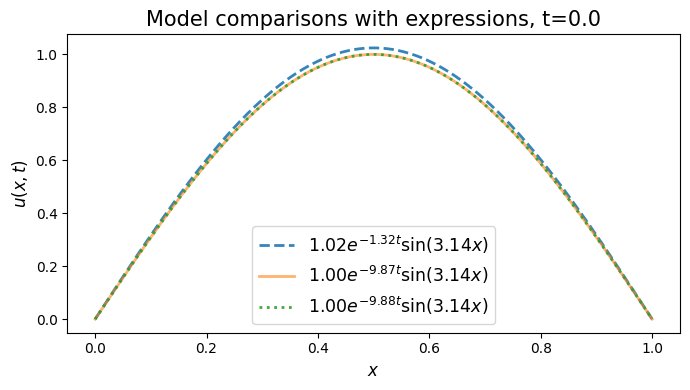

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import least_squares


torch.set_default_dtype(torch.float32)



def fit_ABC(x, t, u, theta0):
    """
    Fit u(x,t) ≈ A exp(B t) sin(C x) by nonlinear least squares.
    x, t, u : 1D numpy arrays of same length.
    """
    def residual(theta):
        A, B, C = theta
        return A * np.exp(B * t) * np.sin(C * x) - u

    res = least_squares(residual, theta0, method="trf")
    return res.x  # (A, B, C)



def fit_coefficients_from_pinn(pinn, x_eval, t_eval):
    Xg, Tg = np.meshgrid(x_eval, t_eval, indexing="ij")
    x_fit = Xg.ravel()
    t_fit = Tg.ravel()

    device = pinn.device if hasattr(pinn, "device") else "cpu"
    x_torch = torch.tensor(x_fit, dtype=torch.float32, device=device).view(-1, 1)
    t_torch = torch.tensor(t_fit, dtype=torch.float32, device=device).view(-1, 1)

    with torch.no_grad():
        u_pred = pinn.trial_solution(x_torch, t_torch).cpu().numpy().ravel()

    theta0 = np.array([0.4, -4.73, np.pi])
    A, B, C = fit_ABC(x_fit, t_fit, u_pred, theta0)
    return A, B, C



def fit_coefficients_from_euler(dx, T, alpha):
    # Use your forward_Euler function
    x, t, U = forward_Euler(dx, T, alpha=alpha)

    # U has shape (Nt, Nx) with U[n,i] = u(x_i, t_n)
    # Build (x,t) grid with same ordering as U.T
    Xg, Tg = np.meshgrid(x, t, indexing="ij")  # (Nx, Nt)
    x_fit = Xg.ravel()
    t_fit = Tg.ravel()
    u_fit = U.T.ravel()  # (Nt,Nx) -> (Nx,Nt) then flatten

    theta0 = np.array([0.3, -5.3, np.pi])
    A, B, C = fit_ABC(x_fit, t_fit, u_fit, theta0)
    return A, B, C, x, t, U



layers = [2, 200, 200, 200, 200, 200, 1]
device = "cpu"


pinn_bad = PINN(layers=layers, activation="gelu", device=device)

pinn_good = PINN(layers=layers, activation="gelu", device=device)

N_coll = 100
x_coll = torch.rand(N_coll, 1, device=device)
t_coll = 0.5 * torch.rand(N_coll, 1, device=device)

pinn_good.train_pinn(
    x_coll, t_coll,
    epochs=5000,
    lr=1e-4,
    verbose_every=1000
)
pinn_good.eval()
pinn_bad.train_pinn(
    x_coll, t_coll,
    epochs=10,
    lr=1e-4,
    verbose_every=1000
)


x_eval = np.linspace(0, 1, 40)
t_eval = np.linspace(0, 0.5, 40)

A_bad, B_bad, C_bad = fit_coefficients_from_pinn(pinn_bad, x_eval, t_eval)
print(f"Bad PINN:   A={A_bad:.3f}, B={B_bad:.3f}, C={C_bad:.3f}")

A_good, B_good, C_good = fit_coefficients_from_pinn(pinn_good, x_eval, t_eval)
print(f"Good PINN:  A={A_good:.3f}, B={B_good:.3f}, C={C_good:.3f}")

dx     = 0.01
T_max  = 0.5
alpha  = 0.49  # <-- choose the alpha you want to compare

A_eul, B_eul, C_eul, x_eul, t_eul, U_eul = fit_coefficients_from_euler(dx, T_max, alpha)
print(f"Euler (α={alpha}): A={A_eul:.3f}, B={B_eul:.3f}, C={C_eul:.3f}")


t_target = 0.0
idx_t = np.argmin(np.abs(t_eul - t_target))
t_plot = t_eul[idx_t]

x_plot = np.linspace(0.0, 1.0, 300)


u_bad_expr  = A_bad  * np.exp(B_bad  * t_plot) * np.sin(C_bad  * x_plot)
u_good_expr = A_good * np.exp(B_good * t_plot) * np.sin(C_good * x_plot)
u_eul_expr  = A_eul  * np.exp(B_eul  * t_plot) * np.sin(C_eul  * x_plot)

plt.figure(figsize=(7,4))

plt.plot(
    x_plot, u_bad_expr,
    linestyle="--", linewidth=2, alpha=0.9,
    label=fr"${A_bad:.2f} e^{{{B_bad:.2f} t}}\sin({C_bad:.2f}x)$"
)

plt.plot(
    x_plot, u_eul_expr,
    linestyle="-", linewidth=2, alpha=0.6,
    label=fr"${A_eul:.2f} e^{{{B_eul:.2f} t}}\sin({C_eul:.2f}x)$"
)

plt.plot(
    x_plot, u_good_expr,
    linestyle=":", linewidth=2, alpha=0.9,
    label=fr"${A_good:.2f} e^{{{B_good:.2f} t}}\sin({C_good:.2f}x)$"
)

plt.xlabel("$x$", fontsize=12)
plt.ylabel("$u(x,t)$", fontsize=12)
plt.title(fr"Model comparisons with expressions, t={t_target:.1f}", fontsize=15)
plt.legend(fontsize=12.5)
plt.tight_layout()
plt.show()


Euler alpha=0.50: MSE = 2.06e-05
Euler alpha=0.55: MSE = 2.60e-05
Euler alpha=0.60: MSE = 1.97e-05
Euler alpha=0.62: MSE = 2.24e-05
Euler alpha=0.65: MSE = 7.72e-01

Training PINN with N_coll = 50
  Time: 3.92 s | MSE: 2.03e-03

Training PINN with N_coll = 100
  Time: 5.29 s | MSE: 3.44e-04

Training PINN with N_coll = 200
  Time: 6.20 s | MSE: 6.29e-04

Training PINN with N_coll = 400
  Time: 6.81 s | MSE: 2.06e-04

Training PINN with N_coll = 800
  Time: 12.09 s | MSE: 2.60e-04


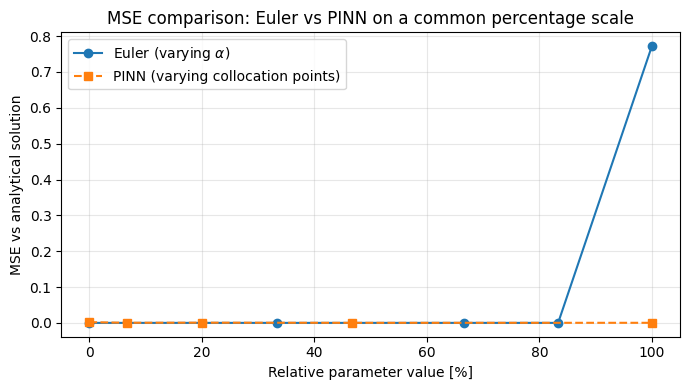

In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from classes import PINN   

torch.set_default_dtype(torch.float32)
device = "cpu"   



def u_exact(x, t):
    """Analytical solution: u(x,t) = exp(-pi^2 t) sin(pi x)."""
    x = np.asarray(x)
    t = np.asarray(t)
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

def forward_Euler(dx, T, alpha=0.5, L=1.0):
    """
    Explicit forward Euler for u_t = u_xx on [0,L]
    with u(x,0)=sin(pi x), u(0,t)=u(L,t)=0
    using dt = alpha * dx^2.
    """
    Nx = int(L / dx) + 1
    x = np.linspace(0.0, L, Nx)

    dt = alpha * dx**2
    Nt = int(T / dt) + 1
    T_arr = np.linspace(0.0, T, Nt)

    U = np.zeros((Nt, Nx))
    U[0, :] = np.sin(np.pi * x)
    U[0, 0] = 0.0
    U[0, -1] = 0.0

    for n in range(Nt - 1):
        u = U[n, :]
        u_new = u.copy()
        u_new[1:-1] = u[1:-1] + alpha * (u[2:] - 2*u[1:-1] + u[:-2])
        u_new[0]  = 0.0
        u_new[-1] = 0.0
        U[n+1, :] = u_new

    return x, T_arr, U


T_max = 0.5
dx = 0.09
alphas = [0.5, 0.55, 0.6, 0.625, 0.65]   

mse_euler = []

for alpha in alphas:
    x_eul, t_eul, U_eul = forward_Euler(dx, T_max, alpha=alpha)
    Xg, Tg = np.meshgrid(x_eul, t_eul, indexing="ij")

    u_ref = u_exact(Xg.ravel(), Tg.ravel())
    u_num = U_eul.T.ravel()

    mse_val = np.mean((u_num - u_ref)**2)
    mse_euler.append(mse_val)

    print(f"Euler alpha={alpha:.2f}: MSE = {mse_val:.2e}")



def train_pinn_manual(N_coll, epochs=1200, lr=1e-3):
    """Train one PINN with N_coll collocation points."""

    layers = [2, 50, 50, 1]
    pinn = PINN(layers=layers, activation="tanh", device=device)
    pinn.to(device)

    x_coll = torch.rand(N_coll, 1, device=device)
    t_coll = torch.rand(N_coll, 1, device=device) * T_max

    optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)

    start = time.perf_counter()
    for ep in range(epochs):
        optimizer.zero_grad()
        loss = pinn.loss(x_coll, t_coll)
        loss.backward()
        optimizer.step()
    end = time.perf_counter()

    return pinn, end - start

Nx_eval, Nt_eval = 50, 50
x_eval = np.linspace(0.0, 1.0, Nx_eval)
t_eval = np.linspace(0.0, T_max, Nt_eval)
Xg_eval, Tg_eval = np.meshgrid(x_eval, t_eval, indexing="ij")
x_flat = Xg_eval.ravel()
t_flat = Tg_eval.ravel()
u_ref_eval = u_exact(x_flat, t_flat)

colloc_list = [50, 100, 200, 400, 800]
mse_pinn = []
time_pinn = []

for N_coll in colloc_list:
    print(f"\nTraining PINN with N_coll = {N_coll}")
    pinn, train_time = train_pinn_manual(N_coll)
    time_pinn.append(train_time)

    with torch.no_grad():
        x_torch = torch.tensor(x_flat, dtype=torch.float32, device=device).view(-1, 1)
        t_torch = torch.tensor(t_flat, dtype=torch.float32, device=device).view(-1, 1)
        u_pred = pinn.trial_solution(x_torch, t_torch).cpu().numpy().ravel()

    mse_val = np.mean((u_pred - u_ref_eval)**2)
    mse_pinn.append(mse_val)

    print(f"  Time: {train_time:.2f} s | MSE: {mse_val:.2e}")



alphas_arr = np.array(alphas, dtype=float)
colloc_arr = np.array(colloc_list, dtype=float)

eul_norm  = (alphas_arr - alphas_arr.min()) / (alphas_arr.max() - alphas_arr.min())
pinn_norm = (colloc_arr - colloc_arr.min()) / (colloc_arr.max() - colloc_arr.min())

eul_pct  = 100 * eul_norm
pinn_pct = 100 * pinn_norm




plt.figure(figsize=(7, 4))

plt.plot(
    eul_pct, mse_euler, "o-", label="Euler (varying $\\alpha$)"
)
plt.plot(
    pinn_pct, mse_pinn, "s--", label="PINN (varying collocation points)"
)

plt.xlabel("Relative parameter value [%]")
plt.ylabel("MSE vs analytical solution")
plt.title("MSE comparison: Euler vs PINN on a common percentage scale")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
